# Setup

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print('TensorFlow version:  ', tf.__version__)
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

TensorFlow version:   2.4.1


In [ ]:
# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

# Login with Google Account
from google.colab import auth
auth.authenticate_user()

In [2]:
!gsutil cp 'gs://quickdraw_dataset/full/numpy_bitmap/cat.npy' .
!gsutil cp 'gs://quickdraw_dataset/full/numpy_bitmap/dog.npy' .
!gsutil cp 'gs://quickdraw_dataset/full/numpy_bitmap/mouse.npy' .

Copying gs://quickdraw_dataset/full/numpy_bitmap/cat.npy...
- [1 files][ 92.1 MiB/ 92.1 MiB]                                                
Operation completed over 1 objects/92.1 MiB.                                     
Copying gs://quickdraw_dataset/full/numpy_bitmap/dog.npy...
\ [1 files][113.8 MiB/113.8 MiB]                                                
Operation completed over 1 objects/113.8 MiB.                                    
Copying gs://quickdraw_dataset/full/numpy_bitmap/mouse.npy...
\ [1 files][133.7 MiB/133.7 MiB]                                                
Operation completed over 1 objects/133.7 MiB.                                    


# Visualize input data

In [5]:
cat = np.load('cat.npy')
dog = np.load('dog.npy')
mouse = np.load('mouse.npy')
print('Shapes:\n cat {} \n dog {} \n mouse {}'.format(cat.shape, dog.shape, mouse.shape))

Shapes:
 cat (123202, 784) 
 dog (152159, 784) 
 mouse (178826, 784)


Function from github.com/kradolfer/quickdraw-image-recognition/

In [8]:
def plot_samples(input_array, rows=4, cols=5, title=''):
    """
    Function to plot 28x28 pixel drawings that are stored in a numpy array.
    Specify how many rows and cols of pictures to display (default 4x5).  
    If the array contains less images than subplots selected, 
    surplus subplots remain empty.
    """
    
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

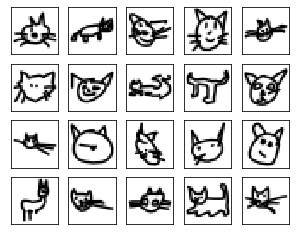

In [9]:
plot_samples(cat)

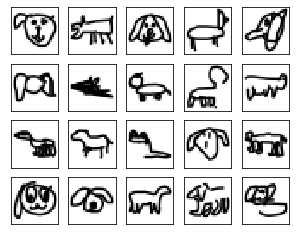

In [53]:
plot_samples(dog)

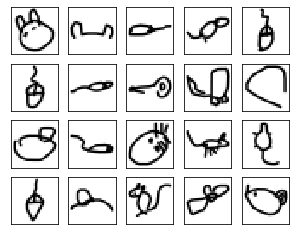

In [54]:
plot_samples(mouse)

# Data Preprocessing

In [37]:
# Make train-test set from *.npy data
N_SAMPLES = 50000
TEST_RATIO = 0.02

CATEGORY_DICT = {
    'cat': 0,
    'dog': 1,
    'mouse': 2
}

def get_train_test_data():
    """
    Loads data from *.npy files by category and
    creates train-test split.
    """
    X_data = []
    y_labels = []
    # get data for each category
    for category, enc in CATEGORY_DICT.items():
        # load numpy data from storage
        np_data = np.load(f'{category}.npy')
        # select random subset acc. to N_SAMPLES
        np.random.shuffle(np_data)
        X_category = np_data[0:N_SAMPLES,:]
        # encode label
        y_category = np.zeros(N_SAMPLES) + enc
        # add to set
        X_data.append(X_category)
        y_labels.append(y_category)
    # create numpy array and fix shapes
    X_data = np.asarray(X_data)
    X_data = X_data.reshape(-1, X_data.shape[2])
    y_labels = np.asarray(Y_labels).flatten()
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_labels, test_size=TEST_RATIO, random_state=42
        )
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_data()

# Print data shapes
print('Training data shapes: \n data: {} \n labels: {}'.format(
    X_train.shape, y_train.shape
    ))
print('Test data shapes: \n data: {} \n labels: {}'.format(
    X_test.shape, y_test.shape
    ))

Training data shapes: 
 data: (147000, 784) 
 labels: (147000,)
Test data shapes: 
 data: (3000, 784) 
 labels: (3000,)


In [38]:
# Create tensorflow dataset
BATCH_SIZE = 128
BUFFER_SIZE = 256

def input_fn(X_train, X_test, y_train, y_test):
    """
    Takes numpy train-test data and converts it into a tf.data.Dataset
    """

    # preprocessing functions
    def _fixup_shape(features, label):
        features = tf.reshape(features, [28, 28, 1])
        return features, label
    def _normalize(features, label):
        features = tf.math.divide(features, 255)
        return features, label

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    train_ds = train_ds.map(_fixup_shape) \
                    .map(_normalize)
    train_ds = train_ds.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

    test_ds = test_ds.map(_fixup_shape) \
                    .map(_normalize)
    test_ds = test_ds.batch(1)

    return train_ds, test_ds

train_ds, test_ds = input_fn(X_train, X_test, y_train, y_test)

# Print shapes
for feat, label in train_ds.take(1):
    print(feat.shape)
    print(label.shape)

(128, 28, 28, 1)


# Train CNN


In [12]:
# Create keras model
NUM_CLASSES = 3

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
if NUM_CLASSES == 2:
    model.add(layers.Dense(1)) # binary model
else:
    model.add(layers.Dense(NUM_CLASSES)) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [13]:
# Compile model
if NUM_CLASSES == 2:
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
else:
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [14]:
# Train model
TRAIN_STEPS = 10

history = model.fit(train_ds, 
                    epochs=TRAIN_STEPS, 
                    steps_per_epoch=None,
                    validation_data=test_ds,
                    validation_freq=1,
                    verbose=1)
model.save('model.h5')

Epoch 1/10
1149/1149 [==============================] - 124s 107ms/step - loss: 0.5914 - accuracy: 0.7545 - val_loss: 0.4015 - val_accuracy: 0.8493
Epoch 2/10
1149/1149 [==============================] - 122s 106ms/step - loss: 0.3855 - accuracy: 0.8502 - val_loss: 0.3759 - val_accuracy: 0.8497
Epoch 3/10
1149/1149 [==============================] - 122s 106ms/step - loss: 0.3479 - accuracy: 0.8651 - val_loss: 0.3595 - val_accuracy: 0.8547
Epoch 4/10
1149/1149 [==============================] - 122s 107ms/step - loss: 0.3282 - accuracy: 0.8727 - val_loss: 0.3493 - val_accuracy: 0.8557
Epoch 5/10
1149/1149 [==============================] - 123s 107ms/step - loss: 0.3114 - accuracy: 0.8798 - val_loss: 0.3467 - val_accuracy: 0.8633
Epoch 6/10
1149/1149 [==============================] - 122s 107ms/step - loss: 0.2964 - accuracy: 0.8866 - val_loss: 0.3531 - val_accuracy: 0.8613
Epoch 7/10
1149/1149 [==============================] - 122s 106ms/step - loss: 0.2808 - accuracy: 0.8925 - val_

In [15]:
for feat, label in test_ds.shuffle(buffer_size=128).take(4):
    pred = model.predict(feat)
    print('Logits: \t', pred[0])
    print('Prediction:\t {}\nTrue Label:\t {}'.format(np.argmax(pred), int(label[0])))

Logits: 	 [ 2.6699762 -3.006159  -1.3935195]
Prediction:	 0
True Label:	 0
Logits: 	 [ 4.184852  -2.0730886 -3.3455923]
Prediction:	 0
True Label:	 0
Logits: 	 [ 7.7422338 -5.121661  -2.1475973]
Prediction:	 0
True Label:	 0
Logits: 	 [-3.7341092 -3.338173   5.508769 ]
Prediction:	 2
True Label:	 2


# Export model for TensorFlow.JS


In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

# Debugging Area

In [ ]:
# nothing here!